In [2]:
## Assignement 10 - ML Mini Project - Supervised -- Submitted by John Manuel
##                                               -- Submitted to Abayomi Bello


## import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight


## neural network library
from keras.models import Sequential
from keras.layers import Dense, Dropout
from mlxtend.plotting import plot_confusion_matrix
import pickle


In [3]:
## Load the dataset
fraud = pd.read_csv("fraud.csv")
fraud.head(100)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
95,1,TRANSFER,710544.77,C835773569,0.0,0.00,C1359044626,738531.50,16518.36,0,0
96,1,TRANSFER,581294.26,C843299092,0.0,0.00,C1590550415,5195482.15,19169204.93,0,0
97,1,TRANSFER,11996.58,C605982374,0.0,0.00,C1225616405,40255.00,0.00,0,0
98,1,PAYMENT,2875.10,C1412322831,15443.0,12567.90,M1651262695,0.00,0.00,0,0


In [4]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
## Check for missing values 

missing_counts = fraud.isnull().sum()

print(missing_counts)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [6]:
## Since dataappears to be clean with no missing values, proceed to pre-processing
## Using LabelEncoder 
le = LabelEncoder()
fraud['type'] = le.fit_transform(fraud['type'])

In [7]:
## Drop categories like nameOrig and nameDest as these are IDs
fraud.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [8]:
## Handling '0' values in these categories as '0' might be an error or a suspicious account/transaction
fix = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

## Replace '0' with NaN, then use median to fill using simple imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
fraud[fix] = imputer.fit_transform(fraud[fix])


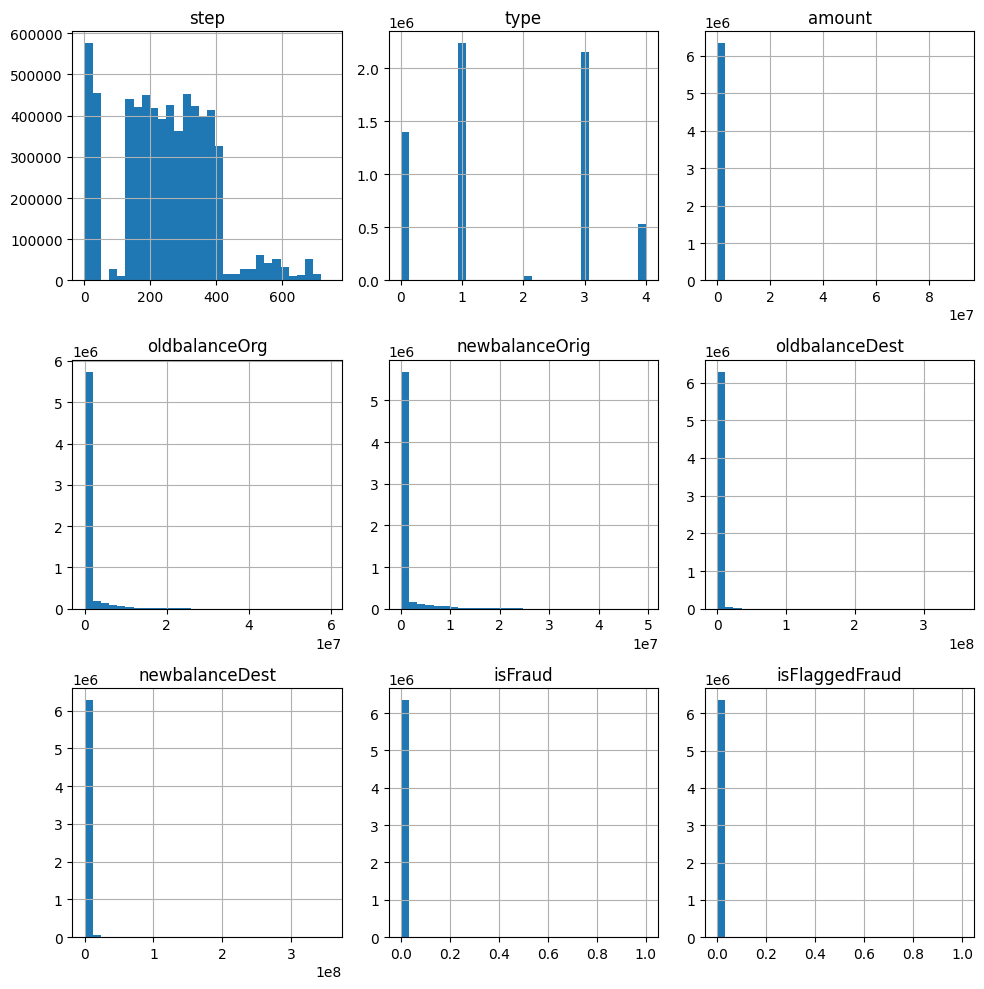

In [9]:
## Visually check the data 
fraud.hist(bins=30, figsize=(10, 10))
plt.tight_layout()    

In [10]:
## How many transactions are fraudulent?
fraud['isFraud'].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

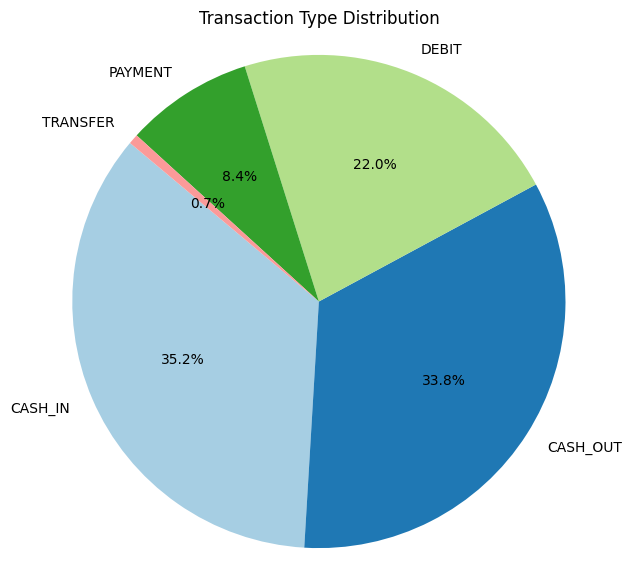

In [11]:
# Count each transaction type
type_counts = fraud['type'].value_counts()
type_labels = le.classes_ ## Label Encoder was used so it is stored in le_classes
# Plot pie chart
plt.figure(figsize=(7, 7))
plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Transaction Type Distribution')
plt.axis('equal') 
plt.show()


In [12]:
fraud['hour'] = fraud['step'] % 24
fraud['day'] = fraud['step'] // 24


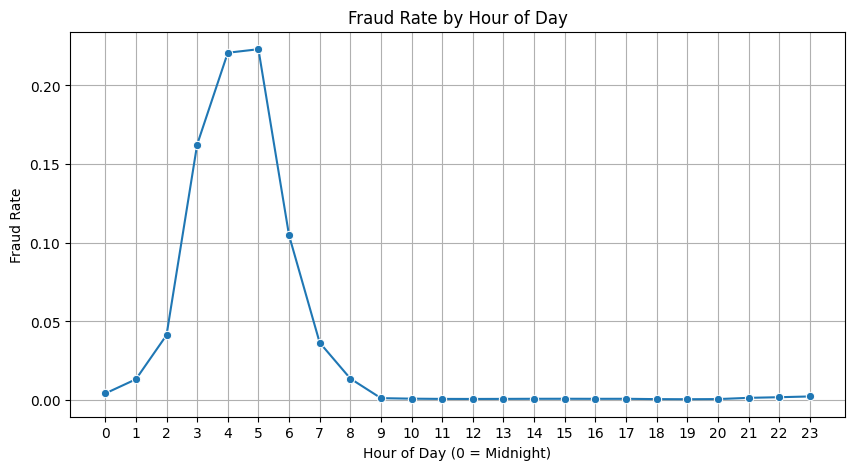

In [13]:
## Fraud rate per hour
hourly_fraud_rate = fraud.groupby('hour')['isFraud'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_fraud_rate.index, y=hourly_fraud_rate.values, marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


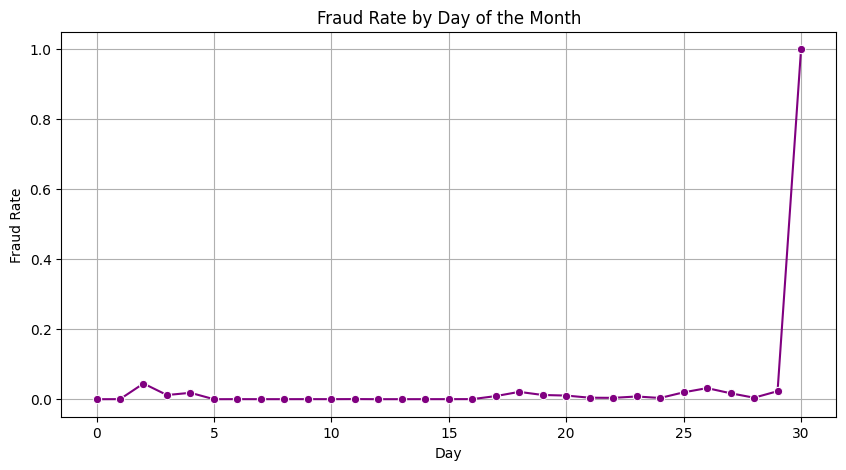

In [14]:
## Fraud rate per day
daily_fraud_rate = fraud.groupby('day')['isFraud'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=daily_fraud_rate.index, y=daily_fraud_rate.values, marker='o', color='purple')
plt.title('Fraud Rate by Day of the Month')
plt.xlabel('Day')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.show()


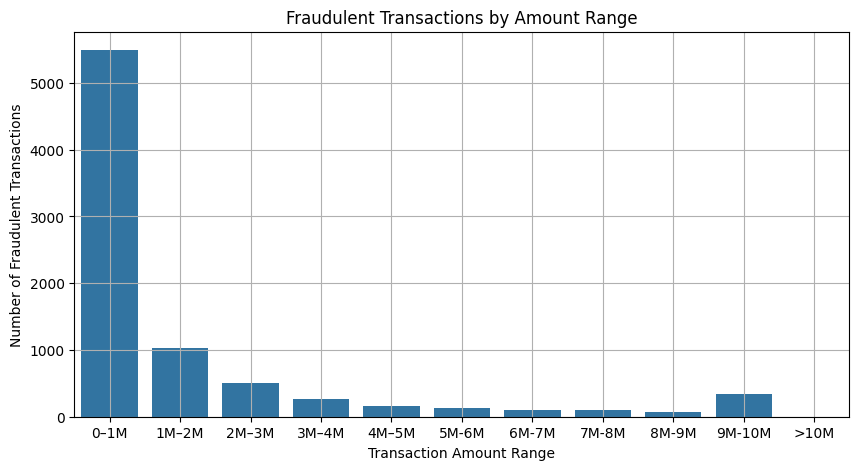

In [15]:

# Filter fraudulent transactions only
fraud_trans = fraud[fraud['isFraud'] == 1].copy()

# Define the range of amount and their labels
bins = [0, 1_000_000, 2_000_000, 3_000_000, 4_000_000, 5_000_000, 6_000_000, 7_000_000, 8_000_000, 9_000_000, 10_000_000, float('inf')]
labels = ['0–1M', '1M–2M', '2M–3M', '3M–4M', '4M–5M', '5M-6M', '6M-7M', '7M-8M', '8M-9M', '9M-10M', '>10M']

# Create a new column for amount range
fraud_trans['amount_range'] = pd.cut(fraud_trans['amount'], bins=bins, labels=labels)

# Count how many fall into each range
range_counts = fraud_trans['amount_range'].value_counts().sort_index()

# Plot the result
plt.figure(figsize=(10, 5))
sns.barplot(x=range_counts.index, y=range_counts.values)
plt.title('Fraudulent Transactions by Amount Range')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Number of Fraudulent Transactions')
plt.grid(True)
plt.show()

In [16]:
## Percentage of transactions by amount
total = range_counts.sum()
fraud_summary = pd.DataFrame({'Count': range_counts,'Percentage': (range_counts / total * 100).round(2)})
print(fraud_summary)

              Count  Percentage
amount_range                   
0–1M           5491       66.99
1M–2M          1026       12.52
2M–3M           507        6.19
3M–4M           263        3.21
4M–5M           166        2.03
5M-6M           125        1.52
6M-7M           102        1.24
7M-8M           105        1.28
8M-9M            68        0.83
9M-10M          344        4.20
>10M              0        0.00


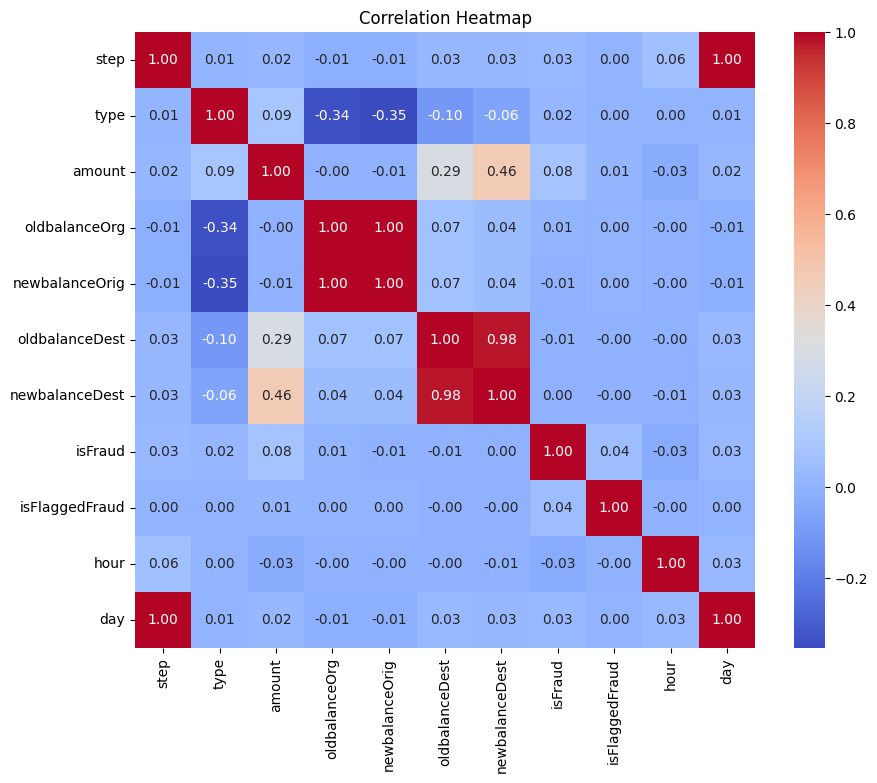

In [17]:

# Select only numeric columns for correlation
heatmap_df = fraud.select_dtypes(include=['int64', 'float64'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [18]:
## Feauture Engineering (check for transaction differences)
# Calculates how much money was deducted from the original account during the transaction -- should match amount
fraud['balanceDiffOrig'] = fraud['oldbalanceOrg'] - fraud['newbalanceOrig']
# Calculates how much money was added to the destination account during the transaction
fraud['balanceDiffDest'] = fraud['newbalanceDest'] - fraud['oldbalanceDest']
# Check transfers of '0' for validity
fraud['isZeroTransfer'] = (fraud['amount'] == 0).astype(int)

In [19]:
## Define x and y columnns 
x = fraud.drop(columns=['isFraud'])
Y = fraud['isFraud']

In [20]:
# Scale the features
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

In [21]:
## train-test split 
x_train, x_test, Y_train,Y_test = train_test_split(x_scaled,Y,test_size=0.2,random_state=42)

In [76]:
## Model testing 
## Logistic Regression Model
model_lr = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, class_weight='balanced')
model_lr.fit(x_train, Y_train)
Y_pred_lr = model_lr.predict(x_test)
print(model_lr.coef_)
## accuracy score
print("\nAccuracy score:", accuracy_score(Y_test,Y_pred_lr))
## confusion matrix
conf_mat_lr = confusion_matrix(Y_test, Y_pred_lr)
print("\nConfusion Matrix:\n", conf_mat_lr)
## Classification Report
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_lr))
pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_lr})

[[ 2.64190983e-01  1.64215662e-01 -1.17086245e+00 -2.17987423e-01
  -3.99490053e-01 -3.65350165e-02  2.09163607e-02  1.42900706e+02
  -7.90414263e-01  2.24520241e-01  3.52721389e-01 -7.98914636e-01
   2.39881890e+02]]

Accuracy score: 0.9656729460505263

Confusion Matrix:
 [[1227389   43515]
 [    167    1453]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98   1270904
           1       0.03      0.90      0.06      1620

    accuracy                           0.97   1272524
   macro avg       0.52      0.93      0.52   1272524
weighted avg       1.00      0.97      0.98   1272524



,Actual,Predicted
3737323,0,0
264914,0,0
85647,0,0
5899326,0,0
2544263,0,0
...,...,...
2210524,0,0
956542,0,0
5474798,0,0
878120,0,0


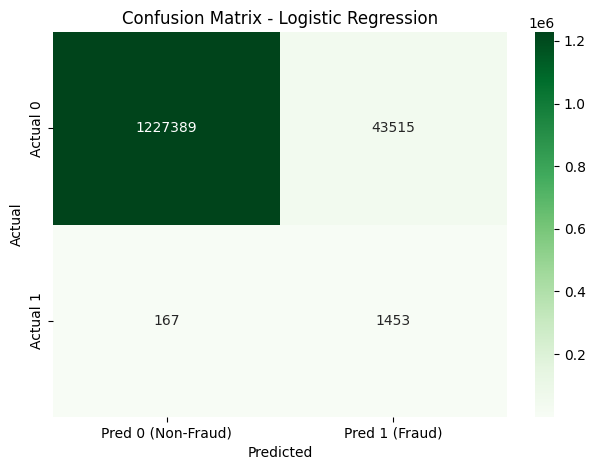

              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1270904
           1       0.03      0.90      0.06      1620

    accuracy                           0.97   1272524
   macro avg       0.52      0.93      0.52   1272524
weighted avg       1.00      0.97      0.98   1272524



In [77]:
# Confusion Matrix and Heatmap for Random Forest model
sns.heatmap(conf_mat_lr, annot=True, fmt='.0f', cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()
print(classification_report(Y_test, Y_pred_lr))

In [23]:
## Random Forest Model 
model_rf = RandomForestClassifier(n_estimators=30, max_depth=10, class_weight='balanced', random_state=42, n_jobs=1)
model_rf.fit(x_train, Y_train)
Y_pred_rf = model_rf.predict(x_test)

## accuracy score
print("\nAccuracy score:", accuracy_score(Y_test,Y_pred_rf))
## confusion matrix
conf_mat_rf = confusion_matrix(Y_test, Y_pred_rf)
print("\nConfusion Matrix:\n", conf_mat_rf)
## Classification Report
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_rf))
pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred_lr})


Accuracy score: 0.9913416171325649

Confusion Matrix:
 [[1259914   10990]
 [     28    1592]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.13      0.98      0.22      1620

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.61   1272524
weighted avg       1.00      0.99      0.99   1272524



,Actual,Predicted
3737323,0,0
264914,0,0
85647,0,0
5899326,0,0
2544263,0,0
...,...,...
2210524,0,0
956542,0,0
5474798,0,0
878120,0,0


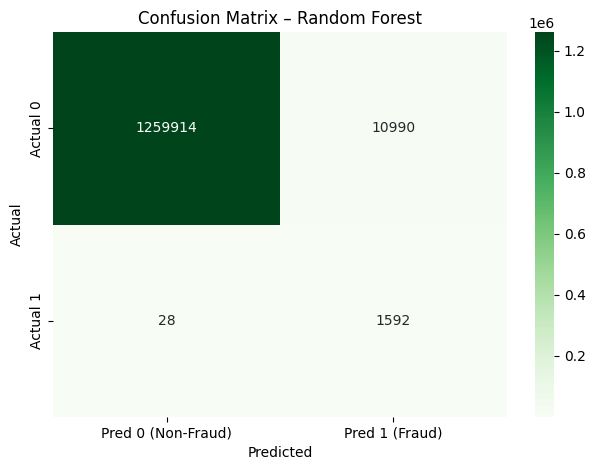

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.13      0.98      0.22      1620

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.61   1272524
weighted avg       1.00      0.99      0.99   1272524



In [24]:
# Confusion Matrix and Heatmap for Random Forest model
sns.heatmap(conf_mat_rf, annot=True, fmt='.0f', cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.show()
print(classification_report(Y_test, Y_pred_rf))

In [25]:
## New sampled sataset to make training feasible and quicker 
# Keep all fraud cases
fraud_cases = fraud[fraud['isFraud'] == 1]
# Randomly sample non-fraud cases (10x size of fraud)
non_fraud_sample = fraud[fraud['isFraud'] == 0].sample(n=len(fraud_cases) * 10, random_state=42)
# Combine and shuffle
sampled_df = pd.concat([fraud_cases, non_fraud_sample]).sample(frac=1, random_state=42)
# Split features and target
X = sampled_df.drop('isFraud', axis=1)
y = sampled_df['isFraud']

In [26]:
## Train sampled data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
## Random Forest Model 
model_rf_sampled = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=1)
model_rf_sampled.fit(X_train, y_train)
y_pred_rf = model_rf_sampled.predict(X_test)

## accuracy score
print("\nAccuracy score:", accuracy_score(y_test,y_pred_rf))
## confusion matrix
conf_mat_rf_sampled = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", conf_mat_rf_sampled)
## Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})


Accuracy score: 0.9964026786208423

Confusion Matrix:
 [[16404    22]
 [   43  1600]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     16426
           1       0.99      0.97      0.98      1643

    accuracy                           1.00     18069
   macro avg       0.99      0.99      0.99     18069
weighted avg       1.00      1.00      1.00     18069



,Actual,Predicted
568633,0,0
3032786,0,0
1116346,0,0
3422918,0,0
2559453,0,0
...,...,...
5087539,0,0
1897229,0,0
2695445,0,0
1053980,0,0


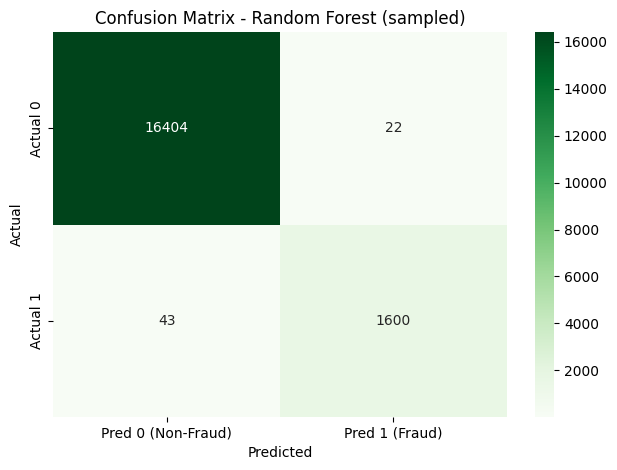

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16426
           1       0.99      0.97      0.98      1643

    accuracy                           1.00     18069
   macro avg       0.99      0.99      0.99     18069
weighted avg       1.00      1.00      1.00     18069



In [78]:
# Confusion Matrix and Heatmap for Random Forest model
sns.heatmap(conf_mat_rf_sampled, annot=True, fmt='.0f', cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (sampled)")
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_rf))

In [29]:
## svm takes a long time to run with up to 60 mins in a full dataset, this is due to SVM performing poorly on big, unbalanced datasets
#  a balanced, undersampled dataset is created whle keeping all fraud data

# Initialise SVC models with class_weight
svm_linear = svm.SVC(kernel='linear', class_weight='balanced')
svm_sigmoid = svm.SVC(kernel='sigmoid', class_weight='balanced')
svm_rbf     = svm.SVC(kernel='rbf', class_weight='balanced')

# Fit the models
svm_linear.fit(X_train, y_train)
svm_sigmoid.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

# Predict
y_pred_linear = svm_linear.predict(X_test)
y_pred_sigmoid = svm_sigmoid.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

# Evaluate
print("Linear Kernel Accuracy:", metrics.accuracy_score(y_test, y_pred_linear))
print("Sigmoid Kernel Accuracy:", metrics.accuracy_score(y_test, y_pred_sigmoid))
print("RBF Kernel Accuracy:", metrics.accuracy_score(y_test, y_pred_rbf))

Linear Kernel Accuracy: 0.9575516077259395
Sigmoid Kernel Accuracy: 0.8535613481653661
RBF Kernel Accuracy: 0.9603187780175992


In [30]:
# ## confussion matrix for the kernels
conf_mat_linear = (confusion_matrix(y_test, y_pred_linear))
conf_mat_sigmoid = confusion_matrix(y_test, y_pred_sigmoid)
conf_mat_rbf = confusion_matrix(y_test, y_pred_rbf)

print(conf_mat_linear)
print(conf_mat_sigmoid)
print(conf_mat_rbf)

[[15828   598]
 [  169  1474]]
[[14031  2395]
 [  251  1392]]
[[15876   550]
 [  167  1476]]


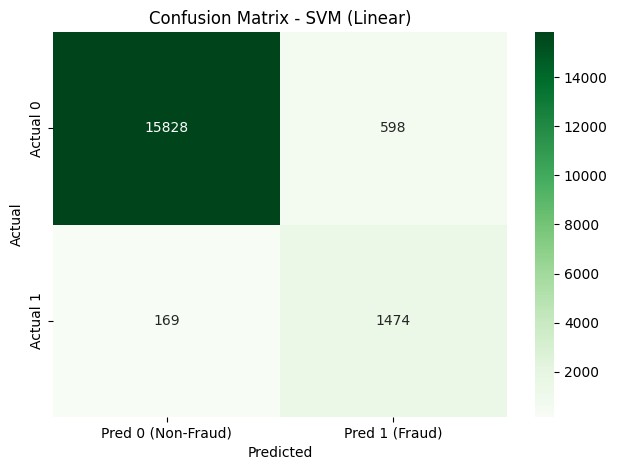

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     16426
           1       0.71      0.90      0.79      1643

    accuracy                           0.96     18069
   macro avg       0.85      0.93      0.88     18069
weighted avg       0.96      0.96      0.96     18069



In [31]:
# Confusion Matrix and Heatmap for SVM models
sns.heatmap(conf_mat_linear, annot=True, fmt='.0f', cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (Linear)")
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_linear))

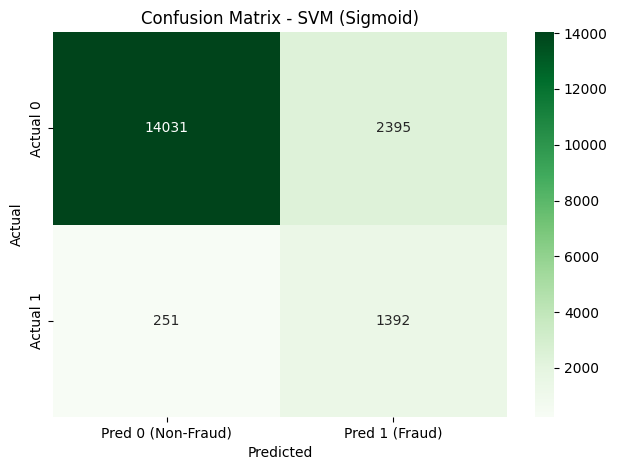

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     16426
           1       0.37      0.85      0.51      1643

    accuracy                           0.85     18069
   macro avg       0.67      0.85      0.71     18069
weighted avg       0.93      0.85      0.88     18069



In [32]:
# Sigmoid
sns.heatmap(conf_mat_sigmoid, annot=True, fmt='.0f', cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (Sigmoid)")
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_sigmoid))

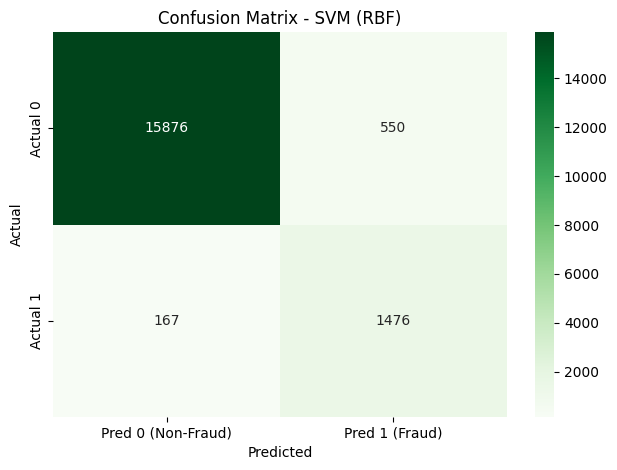

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     16426
           1       0.73      0.90      0.80      1643

    accuracy                           0.96     18069
   macro avg       0.86      0.93      0.89     18069
weighted avg       0.97      0.96      0.96     18069



In [33]:
# RBF
sns.heatmap(conf_mat_rbf, annot=True, fmt='.0f', cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (RBF)")
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_rbf))

In [56]:
auc_lr = roc_auc_score(Y_test, Y_pred_lr)
auc_rf = roc_auc_score(Y_test, Y_pred_rf)
auc_rf_sampled = roc_auc_score(y_test, y_pred_rf)
auc_linear = roc_auc_score(y_test, y_pred_linear)
auc_sigmoid = roc_auc_score(y_test, y_pred_sigmoid)
auc_rbf = roc_auc_score(y_test, y_pred_rbf)
print('Logistic Regression - AUC: %f' %auc_lr)
print('Random Forest - AUC: %f' %auc_rf)
print('Random Forest sampled - AUC: %f' %auc_rf_sampled)
print('Linear - AUC: %f' %auc_linear)
print('Sigmoid - AUC: %f' %auc_sigmoid)
print('RBF - AUC: %f' %auc_rbf)

Logistic Regression - AUC: 0.931337
Random Forest - AUC: 0.987034
Random Forest sampled - AUC: 0.986245
Linear - AUC: 0.930367
Sigmoid - AUC: 0.850713
RBF - AUC: 0.932437


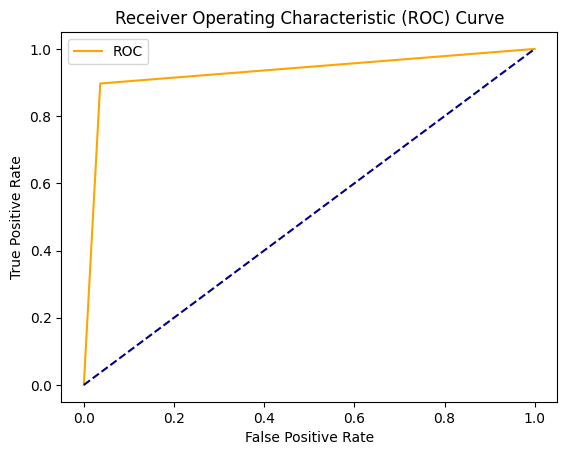

In [35]:
# ROC Curve for Logistic Regression, Random Forest and SVM models
fpr, tpr = roc_curve(y_test, y_pred_linear)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# 1 Hidden Layer
# Initialise the NN
model1 = Sequential()

# input layer 
## 13 features, it will automatically take care of the samples 
model1.add(Input(shape=(13,)))

# Hidden layer 1
model1.add(Dense(units=6, kernel_initializer='he_uniform', activation='relu'))
model1.add(Dropout(0.4))

# Output layer
## binary classification which will produce 0 and 1 we use the sigmoid activation function 
model1.add(Dense(units=1, kernel_initializer='he_uniform', activation='sigmoid'))

# Compile the ANN
## mean squared error
## metrics mae
## categorical_crossentropy
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history1 = model1.fit(X_train, y_train, batch_size=25, epochs=40, validation_split=0.25)

# prediction
y_pred_1 = (model1.predict(X_test) > 0.5).astype("int")


Epoch 1/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8564 - loss: 0.6787 - val_accuracy: 0.9732 - val_loss: 0.0885
Epoch 2/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9596 - loss: 0.1304 - val_accuracy: 0.9774 - val_loss: 0.0760
Epoch 3/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9621 - loss: 0.1190 - val_accuracy: 0.9787 - val_loss: 0.0718
Epoch 4/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9642 - loss: 0.1114 - val_accuracy: 0.9775 - val_loss: 0.0704
Epoch 5/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9644 - loss: 0.1159 - val_accuracy: 0.9802 - val_loss: 0.0670
Epoch 6/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9664 - loss: 0.1061 - val_accuracy: 0.9801 - val_loss: 0.0676
Epoch 7/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9648 - loss: 0.1309 - val_accuracy: 0.9802 - val_loss: 0.0658
Epoch 8/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9657 - loss: 0.1072 - 

In [38]:
val_accuracy = np.mean(history1.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 98.43%


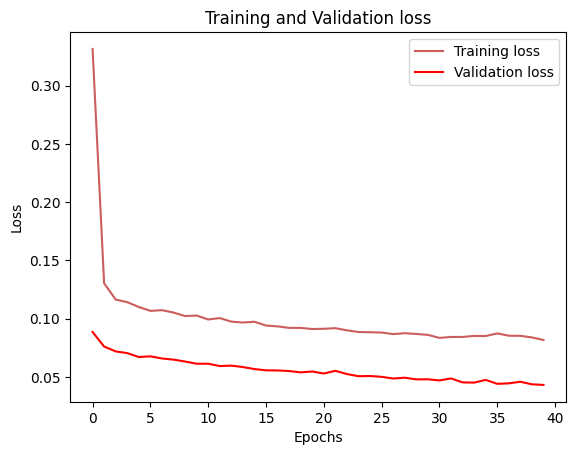

In [39]:
# Training and Validation Loss Graph for 2-layer NN Model
history_df = pd.DataFrame(history1.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

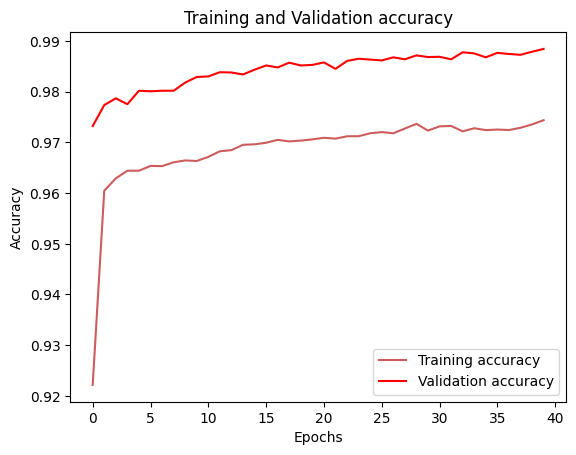

In [40]:
# Training and Validation Accuracy Graph for 1-Layer NN model
history_df = pd.DataFrame(history1.history)

plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step


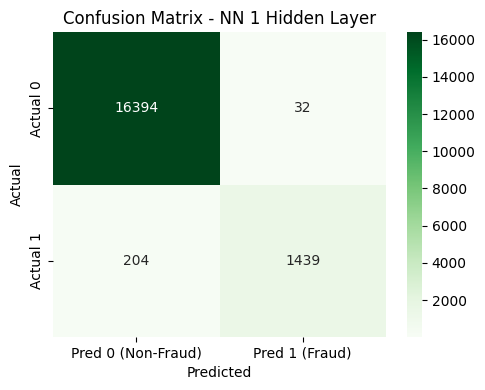

Classification Report – 1 Hidden Layer
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16426
           1       0.98      0.88      0.92      1643

    accuracy                           0.99     18069
   macro avg       0.98      0.94      0.96     18069
weighted avg       0.99      0.99      0.99     18069



In [49]:
# Confusion Matrix and Classification Report for the 1-Layer NN Model
y_pred_prob = model1.predict(X_test)
y_pred = (y_pred_1 > 0.4).astype("int")
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
#  Plot heatmap
plt.figure(figsize=(5, 4))

sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NN 1 Hidden Layer")
plt.tight_layout()
plt.show()
print("Classification Report – 1 Hidden Layer")
print(classification_report(y_test, y_pred))


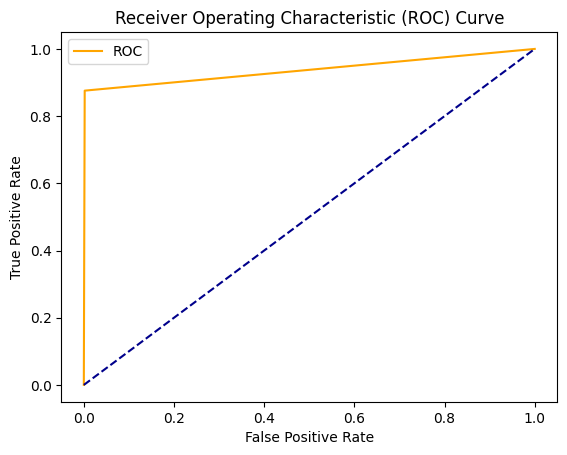

In [42]:
# ROC-AUC curve for the 1-Layer NN model
fpr, tpr = roc_curve(y_test, y_pred_1)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# 2 Hidden Layer NN Model
# Initialise the NN
model2 = Sequential()

# input layer 
## 13 features, it will automatically take care of the samples 
model2.add(Input(shape=(13,)))

# Hidden layer 1
model2.add(Dense(units=6, kernel_initializer='he_uniform', activation='relu'))
model2.add(Dropout(0.4))

# Hidden layer 2
model2.add(Dense(units=4, kernel_initializer='he_uniform', activation='relu'))
model2.add(Dropout(0.2))

# Output layer
# for regression, no activation function
# 0 and 1 ------ 1
# multi-class classification -- 1,2,3,4 ---- 4

## multi class clasification --- softmax --- number of classes that you have as output
## binary classification which will produce 0 and 1 we use the sigmoid activation function 
model2.add(Dense(units=1, kernel_initializer='he_uniform', activation='sigmoid'))

# Compile the ANN
## mean squared error
## metrics mae
## categorical_crossentropy
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history2 = model2.fit(X_train, y_train, batch_size=25, epochs=40, validation_split=0.25)


Epoch 1/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8695 - loss: 1.2961 - val_accuracy: 0.9295 - val_loss: 0.1515
Epoch 2/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9226 - loss: 0.2052 - val_accuracy: 0.9444 - val_loss: 0.1197
Epoch 3/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9350 - loss: 0.1739 - val_accuracy: 0.9739 - val_loss: 0.0885
Epoch 4/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9403 - loss: 0.1446 - val_accuracy: 0.9760 - val_loss: 0.0821
Epoch 5/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9390 - loss: 0.1437 - val_accuracy: 0.9775 - val_loss: 0.0789
Epoch 6/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9404 - loss: 0.1519 - val_accuracy: 0.9799 - val_loss: 0.0750
Epoch 7/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9413 - loss: 0.1323 - val_accuracy: 0.9810 - val_loss: 0.0750
Epoch 8/40
2169/2169 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9432 - loss: 0.1274 - 

In [44]:
val_accuracy = np.mean(history2.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 97.92%


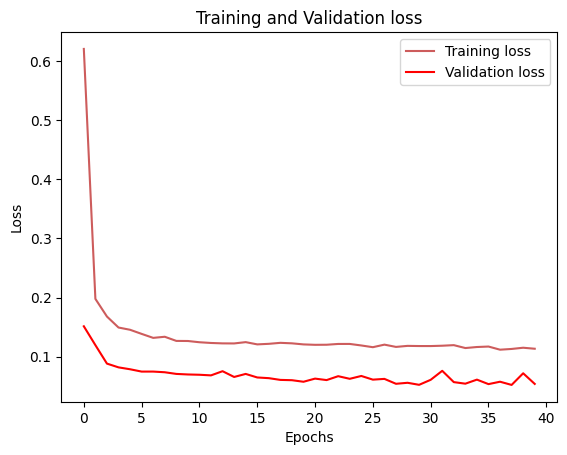

In [45]:
# Training and Validation Loss Graph for 2-layer NN Model
history_dd = pd.DataFrame(history2.history)

plt.plot(history_dd.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_dd.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

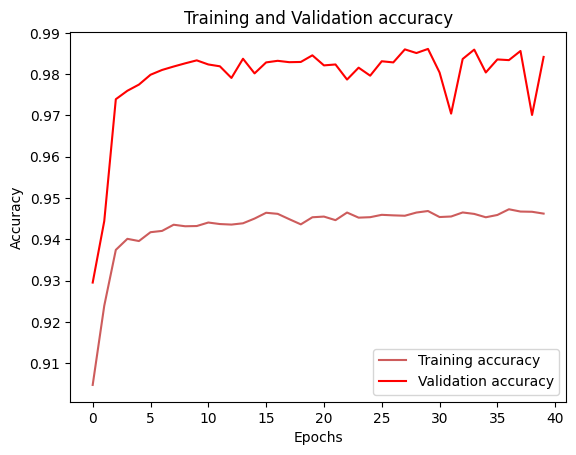

In [46]:
# Training and Validation Accuracy Graph for 2-Layer NN model
history_dd = pd.DataFrame(history2.history)

plt.plot(history_dd.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_dd.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


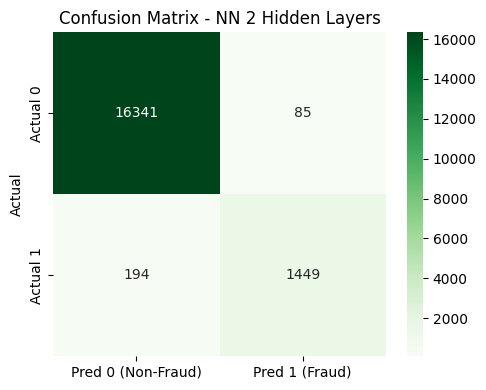

Classification Report – 2 Hidden Layers
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16426
           1       0.94      0.88      0.91      1643

    accuracy                           0.98     18069
   macro avg       0.97      0.94      0.95     18069
weighted avg       0.98      0.98      0.98     18069



In [50]:
# Confusion Matrix and Classification Report for the 2 Layer NN Model
y_pred_2 = model2.predict(X_test)
y_pred2 = (y_pred_2 > 0.4).astype("int")
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred2)
#  Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt=".0f", cmap='Greens', xticklabels=['Pred 0 (Non-Fraud)', 'Pred 1 (Fraud)'],yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel("Actual")
plt.title("Confusion Matrix - NN 2 Hidden Layers")
plt.tight_layout()
plt.show()
print("Classification Report – 2 Hidden Layers")
print(classification_report(y_test, y_pred2))

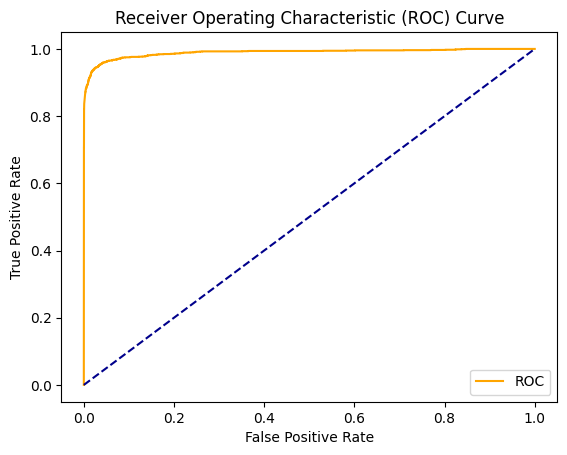

In [48]:
# ROC-AUC curve for the 2-Layer NN model

fpr, tpr = roc_curve(y_test, y_pred_2)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [57]:
auc_lr = roc_auc_score(Y_test, Y_pred_lr)
auc_rf = roc_auc_score(Y_test, Y_pred_rf)
auc_rf_sampled = roc_auc_score(y_test, y_pred_rf)
auc_linear = roc_auc_score(y_test, y_pred_linear)
auc_sigmoid = roc_auc_score(y_test, y_pred_sigmoid)
auc_rbf = roc_auc_score(y_test, y_pred_rbf)
print('Logistic Regression - AUC: %f' %auc_lr)
print('Random Forest - AUC: %f' %auc_rf)
print('Random Forest sampled - AUC: %f' %auc_rf_sampled)
print('Linear - AUC: %f' %auc_linear)
print('Sigmoid - AUC: %f' %auc_sigmoid)
print('RBF - AUC: %f' %auc_rbf)

Logistic Regression - AUC: 0.931337
Random Forest - AUC: 0.987034
Random Forest sampled - AUC: 0.986245
Linear - AUC: 0.930367
Sigmoid - AUC: 0.850713
RBF - AUC: 0.932437


In [79]:
## Classification Report Summary 

# Generate classification reports
report_lr = classification_report(Y_test, Y_pred_lr, output_dict=True)
report_rf = classification_report(Y_test, Y_pred_rf, output_dict=True)
report_rf_sampled = classification_report(y_test, y_pred_rf, output_dict=True)
report_linear = classification_report(y_test, y_pred_linear, output_dict=True)
report_sigmoid = classification_report(y_test, y_pred_sigmoid, output_dict=True)
report_rbf = classification_report(y_test, y_pred_rbf, output_dict=True)
report_nn = classification_report(y_test, y_pred2, output_dict=True)

# Combine into a single DataFrame
report_df = pd.DataFrame({
    'Logistic Regression': pd.Series(report_lr['1']),
    'Random Forest' : pd.Series(report_rf['1']),
    'Random Forest sampled' : pd.Series(report_rf_sampled['1']),
    'SVM Linear': pd.Series(report_linear['1']),
    'SVM Sigmoid': pd.Series(report_sigmoid['1']),
    'SVM RBF': pd.Series(report_rbf['1']),
    'NN Model - 2 Layers' : pd.Series(report_nn['1']),
}).round(2)

# Add accuracy across all models and add as a new row
accuracies = {
    'Logistic Regression': report_lr['accuracy'],
    'Random Forest': report_rf['accuracy'],
    'Random Forest sampled': report_rf_sampled['accuracy'],
    'SVM Linear': report_linear['accuracy'],
    'SVM Sigmoid': report_sigmoid['accuracy'],
    'SVM RBF': report_rbf['accuracy'],
    'NN Model - 2 Layers': report_nn['accuracy'],
}
report_df.loc['accuracy'] = pd.Series(accuracies).round(2)

# Reorder for presentation
report_df = report_df.loc[['precision', 'recall', 'f1-score', 'accuracy', 'support']]

# Display
print("Classification Report Comparison (Class: Fraud + Overall Accuracy)")
print(report_df)

Classification Report Comparison (Class: Fraud + Overall Accuracy)
           Logistic Regression  Random Forest  Random Forest sampled  \
precision                 0.03           0.13                   0.99   
recall                    0.90           0.98                   0.97   
f1-score                  0.06           0.22                   0.98   
accuracy                  0.97           0.99                   1.00   
support                1620.00        1620.00                1643.00   

           SVM Linear  SVM Sigmoid  SVM RBF  NN Model - 2 Layers  
precision        0.71         0.37     0.73                 0.94  
recall           0.90         0.85     0.90                 0.88  
f1-score         0.79         0.51     0.80                 0.91  
accuracy         0.96         0.85     0.96                 0.98  
support       1643.00      1643.00  1643.00              1643.00  


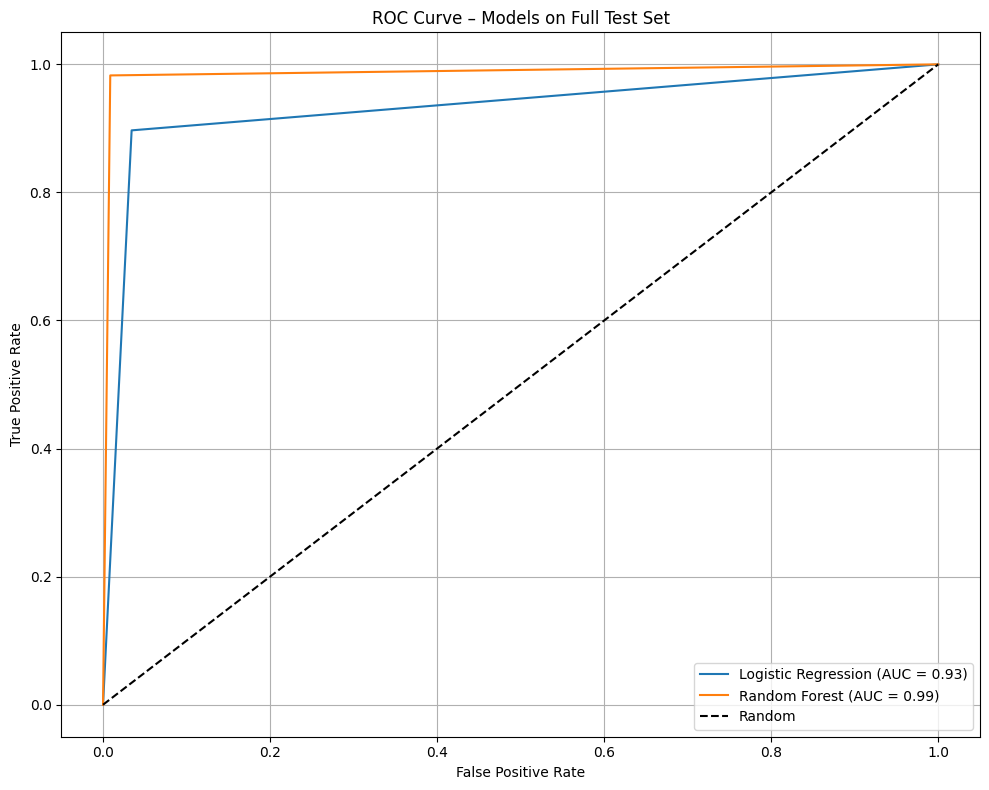

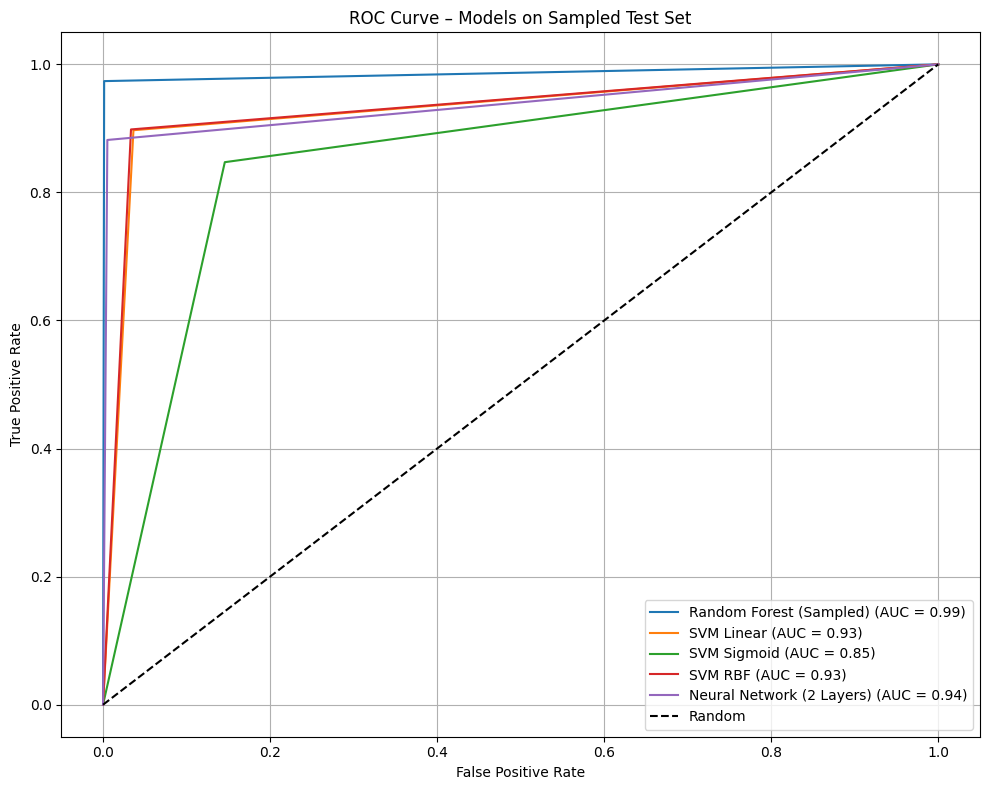

In [74]:
## ROC Curve Summary
# Modelled using full test set
models_full = {
    "Logistic Regression": Y_pred_lr,       
    "Random Forest": Y_pred_rf,
}

y_true_full = Y_test

# Modelled using sampled test set (10x fraud)
models_sampled = {
    "Random Forest (Sampled)": y_pred_rf,
    "SVM Linear": y_pred_linear,
    "SVM Sigmoid": y_pred_sigmoid,
    "SVM RBF": y_pred_rbf,
    "Neural Network (2 Layers)": y_pred2
}

# Use the correct test set
y_true_sampled = y_test  

def plot_roc(models_dict, y_true, title):
    plt.figure(figsize=(10, 8))
    for name, probs in models_dict.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot both curves ---
plot_roc(models_full, y_true_full, "ROC Curve – Models on Full Test Set")
plot_roc(models_sampled, y_true_sampled, "ROC Curve – Models on Sampled Test Set")
